In [ ]:
# !pip install dabest

In [54]:
import os

import dabest
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [44]:
data_path = ('/Users/67981492/Dropbox/loki_0/simple_rt_experiment_probabilityC/analysis/aggregated_data/')
ls_obs_data = pd.read_csv(os.path.join(data_path,'combined_learning_sig_obs_data.csv'))

fig_path = ('/Users/67981492/Dropbox/loki_0_0.5/pcb_submission_figures/')

In [20]:
ls_obs_data.head()

,ID,experiment,condition,trial,shifted_epoch_trial,cp_with_slow_fast,obs_cp_with_slow_fast,p_id_accuracy,rt,lr_choice,...,cumulative_reward,iti,total_trial_time,epoch_n,epoch_trial,n_epoch_trials,prop_112,cpp,ideal_B,target_B
0,761,conflict,hc,0,0,1.0,0.0,1,0.711570,1.0,...,599.0,0.670199,2.385458,1.0,0,36,0.305556,0.099471,0.000000,0.000000
1,761,conflict,hc,1,1,0.0,1.0,0,0.681410,1.0,...,598.0,0.259707,1.939019,1.0,1,36,0.305556,0.035079,-1.241007,0.000000
2,761,conflict,hc,2,2,0.0,0.0,1,0.767118,0.0,...,599.0,0.740615,2.498060,1.0,2,36,0.305556,0.023075,-0.595781,-1.241007
3,761,conflict,hc,3,3,0.0,0.0,0,0.507209,1.0,...,598.0,0.250242,1.742433,1.0,3,36,0.305556,0.019881,-0.306135,-0.595781
4,761,conflict,hc,4,4,0.0,0.0,1,0.656259,1.0,...,599.0,0.700190,2.350417,1.0,4,36,0.305556,0.018539,-0.139394,-0.306135


In [21]:
# rename for plotting legibility 

ls_obs_data.loc[ls_obs_data.condition == 'hc', 'condition'] = 'high conflict'
ls_obs_data.loc[ls_obs_data.condition == 'lc', 'condition'] = 'low conflict'

ls_obs_data.loc[ls_obs_data.condition == 'lv', 'condition'] = 'low volatility'
ls_obs_data.loc[ls_obs_data.condition == 'hv', 'condition'] = 'high volatility'

In [22]:
# mean rt and acc for each subject by condition 

mean_df = ls_obs_data.groupby(['ID', 'condition'], as_index=False )[['p_id_accuracy', 'rt']].mean()
mean_df.head()

,ID,condition,p_id_accuracy,rt
0,761,high conflict,0.681667,0.339351
1,761,high volatility,0.773333,0.305525
2,761,low conflict,0.841667,0.295010
3,761,low volatility,0.860000,0.284506
4,762,high conflict,0.606667,0.388056


In [37]:
# separate acc and rt data for plotting 

acc_df = mean_df.copy().drop('rt', axis=1).pivot(index='ID', columns='condition', values='p_id_accuracy',).reset_index()
rt_df = mean_df.copy().drop('p_id_accuracy', axis=1).pivot(index='ID', columns='condition', values='rt').reset_index()

In [27]:
# indexing for dabest plotting functions

conf_acc_df = dabest.load(acc_df, 
                          idx=['low conflict', 'high conflict'],
                          paired=True, id_col='ID')

vol_acc_df = dabest.load(acc_df, 
                          idx=['low volatility', 'high volatility'],
                          paired=True, id_col='ID')

conf_rt_df = dabest.load(rt_df, 
                          idx=['low conflict', 'high conflict'],
                          paired=True, id_col='ID')

vol_rt_df = dabest.load(rt_df, 
                          idx=['low volatility', 'high volatility'],
                          paired=True, id_col='ID')

In [64]:
np.random.seed(42920) # set random seed for effect size bootstrapping
chance_acc = 0.5

In [129]:
def format_acc_plot(acc_df, chance_acc=chance_acc,
                   custom_palette=['red', 'blue']):
    
    acc_f = acc_df.mean_diff.plot(show_pairs=False, 
                          swarm_label='P(optimal selection)',
                          swarm_ylim = (0.4, 1),
                           custom_palette=custom_palette, 
                           contrast_label='', halfviolin_desat=0.1,
    
                          )
    
    rawswarm_axes = acc_f.axes[0]
    contrast_axes = acc_f.axes[1]

    rawswarm_axes.axhline(linewidth=2, color='k', 
                          y=chance_acc, ls='dashed', alpha=0.3)
    
    return acc_f

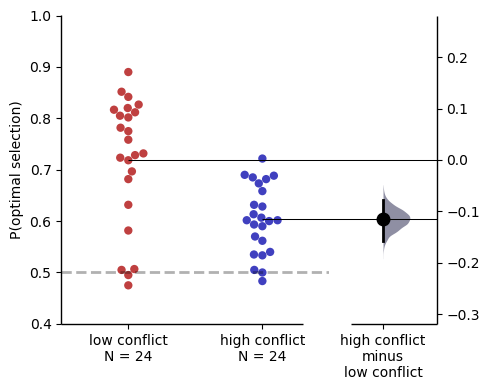

In [130]:
conf_acc_f = format_acc_plot(conf_acc_df)
plt.savefig(os.path.join(fig_path, 'loki0_conf_acc.png'), dpi=600, bbox_inches='tight', transparent=0)

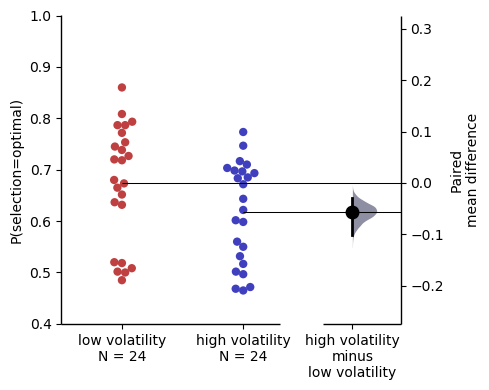

In [117]:
vol_acc_f = vol_acc_df.mean_diff.plot(show_pairs=False, swarm_label='P(selection=optimal)',
                          swarm_ylim = (0.4, 1),
                           custom_palette=['red','blue'],  halfviolin_desat=0.1, )
plt.savefig(os.path.join(fig_path, 'loki0_vol_acc.png'),dpi=600, bbox_inches='tight', transparent=0)

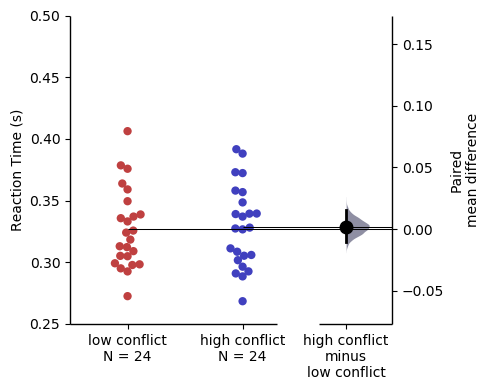

In [119]:
conf_rt_f = conf_rt_df.mean_diff.plot(show_pairs=False, swarm_label='Reaction Time (s)',
                          swarm_ylim = (0.25, 0.50),
                           custom_palette=['red','blue'],   halfviolin_desat=0.1,
                          )
plt.savefig(os.path.join(fig_path, 'loki0_conf_rt.png'), dpi=600, bbox_inches='tight', transparent=0)

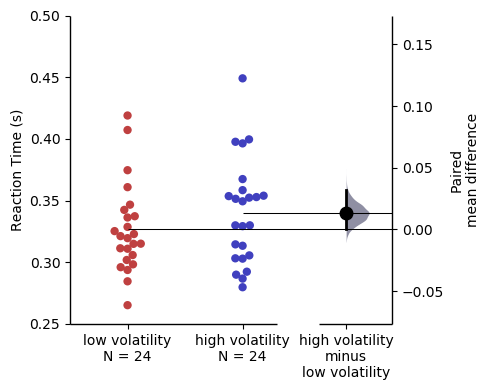

In [118]:
vol_rt_f = vol_rt_df.mean_diff.plot(show_pairs=False, swarm_label='Reaction Time (s)',
                          swarm_ylim = (0.25, 0.50),
                           custom_palette=['red','blue'],   halfviolin_desat=0.1,
                          )
plt.savefig(os.path.join(fig_path, 'loki0_vol_rt.png'),dpi=600, bbox_inches='tight', transparent=0)